# Prediticing Yelp Restaurant Rating

How often do you use Yelp?  I find myself using it often whenever I am in a new town and in desperate need of a food suggestion, because heaven forbid I eat at a restaurant that only gets a 3 star rating when there is a 4 star option down the street.  Yelp has millions of users and reviews, and if a restaurant gets a significant amount of bad reviews, or even just a handful, this can have huge financial implications for the owners.  As such, Yelp is ultimately driven by it's users and the reviews they submit.  Yelp has kindly released a treasure chest of their data to the public for analysis and exploration:   

https://www.yelp.com/dataset_challenge/dataset  

The possibilities with this data set are nearly endless, and here we focus on individual restuaruant reviews.  In particular, we aim to answer the following question:  

**Can we predict the rating of a restaurant on Yelp using a restaurant's attributes?**  

This problem can be reformulated as one of binary classification, as we will see, and from this angle we have a multiple supervised machine learning algorithms at our disposal.  Here we will focus on implementing a Support Vector Machine (SVM) model to predict Yelp restaurant rating from the data provided in the public data set (to be discussed in more details below).  But first, a brief overview of SVM.  

## Support Vector Machines

SVM is a supervised machine learning algorithm that is suited for both classification and regression in high dimensional spaces.  The principle of a SVM is to find a hyperplane that divides a data set into two classes, as shown in the example below. 

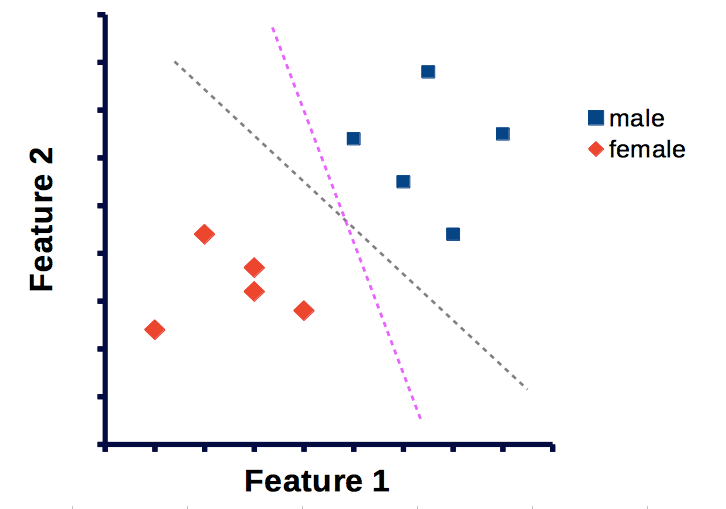

In [5]:
from IPython.display import Image
Image("example1.png")

As shown above, we have identified two hyperplanes, in this case lines, that separate the data into male and female classes based on Feature 1 and Feature 2.  It appears that both the purple and the gray lines classify the data equally well in this case, so how do we know which one is optimal?  To answer this question we introduce the concept of a margin.  The optimal SVM will be the one that maximizes the margin, or distance between separating hyperplanes.  This is illustrated further below.

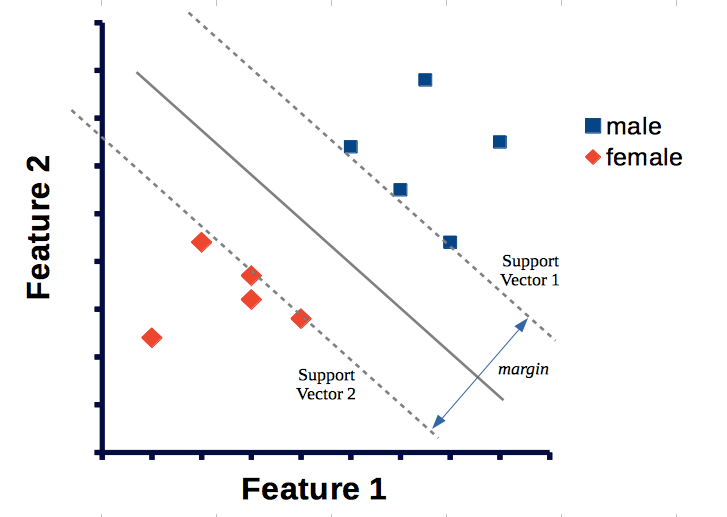

In [6]:
Image("example2.png")

The support vectors that define the margin are typically specified by a small subset of the actual training data, and data points that are far from the support vectors do not determine their positioning.  The input to train a SVM is a set of feature data and classes and the output is a vector of weights (w), one for each features, that maps the feature to a class.  Using this description we can define the hyperplanes in the context of a vector of feature data (x) as:  

\begin{equation*}
w^t * x + b \geq +1, y = +1 \\
w^t * x + b \leq -1, y = -1
\end{equation*}  

Recall that the support vectors are determined by the maximum distance from the separating hyperplane and the first data point that they 'touch'.  Therefore, the distance of the margin can be calculated by determining the distance of the support vector defining feature data from the hyperplane.  The distance between a point and line (https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Line_defined_by_an_equation)  is given by:

\begin{equation*}
distance(ax+by+c = 0, (x_i, y_i)) = \frac{|ax_0+by_0+c|}{\sqrt{a^2+b^2}}
\end{equation*} 

Therefore, the distance from the hyperplane to the support vector defining feature data is:  

\begin{equation*}
\frac{1}{2}margin = \frac{|w^t * x + b|}{||w||}
\end{equation*} 

Remember that:  

\begin{equation*}
|w^t * x + b| = 1
\end{equation*}  

Since the features points that define support vectors are touching the support vector. Taken together, we have the following for the distance of the margin:  

\begin{equation*}
margin = \frac{2}{||w||}
\end{equation*}

Therefore the margin is maximized by minimizing:  

\begin{equation*}
||w||
\end{equation*}  

Thus this turns into an optimization problem.  However, the norm of of w is non-convex, so to make our lives easier instead of minimizing this norm we instead minimize the convex function:  

\begin{equation*}
||w||^2
\end{equation*}  

**Taken together, we can formulate the optimization problem as:**  

\begin{equation*}
minimize: ||w||^2 \\
\end{equation*}   

subject to:  

\begin{equation*}
w^t * x_i + b \geq +1, y_i = +1 \\
w^t * x_i + b \leq -1, y_i = -1
\end{equation*}  

Or, combining these:  

\begin{equation*}
y_i(w^t * x_i + b) \geq 1\\
\end{equation*}  

Note that this optimization problem follows for linearly separable data.  If the data is not linearly separable then we introduce a additional term, a slack variable e and a cost penalty C, to penalize for miss classifications. The function to minimized (for n training data points) can now be re-formulated as:  

\begin{equation*}
minimize: ||w||^2 + C \sum_{i=1}^n e_i\\
\end{equation*}   

The value of the cost penalty determines which term dominates the minimization.  For large C the slack variable contribution will dominate, and we favor models that have a small number of misclassified points.  For a small C, however, we favor models that potentially have more misclassified points, however the margins will be larger.  Solving this optimization is beyond the scope of this post, but there are many fantastic tutorials online if you are interested.  

But enough math.  On to the data!

## Yelp Reviewer Data Set

As mentioned above, Yelp releases a large, rich data set to the public for investigation.  There are 6 data sets in this package, and the one that is useful for our purposes is:  

'yelp_academic_dataset_business.json'  

This data set is a json and contains the following information:  

{  
    "business_id":"encrypted business id",  
    "name":"business name",  
    "neighborhood":"hood name",  
    "address":"full address",  
    "city":"city",  
    "state":"state -- if applicable --",  
    "postal code":"postal code",  
    "latitude":latitude,  
    "longitude":longitude,  
    "stars":star rating, rounded to half-stars,  
    "review_count":number of reviews,  
    "is_open":0/1 (closed/open),  
    "attributes":["an array of strings: each array element is an attribute"],  
    "categories":["an array of strings of business categories"],  
    "hours":["an array of strings of business hours"],  
    "type": "business"  
}    

We will use these attributes to predict "stars", or the business review.  The first step is to import the data and convert to a pandas dataframe.  (side note - pd.read_json( ) is really wonderful).

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import confusion_matrix

In [123]:
bizData = pd.read_json('yelp_academic_dataset_business.json', lines=True)
bizData.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,type
0,"227 E Baseline Rd, Ste J2","[BikeParking: True, BusinessAcceptsBitcoin: Fa...",0DI8Dt2PJp07XkVvIElIcQ,"[Tobacco Shops, Nightlife, Vape Shops, Shopping]",Tempe,"[Monday 11:0-21:0, Tuesday 11:0-21:0, Wednesda...",0,33.378214,-111.936102,Innovative Vapors,,85283,17,4.5,AZ,business
1,495 S Grand Central Pkwy,"[BusinessAcceptsBitcoin: False, BusinessAccept...",LTlCaCGZE14GuaUXUGbamg,"[Caterers, Grocery, Food, Event Planning & Ser...",Las Vegas,"[Monday 0:0-0:0, Tuesday 0:0-0:0, Wednesday 0:...",1,36.192284,-115.159272,Cut and Taste,,89106,9,5.0,NV,business
2,979 Bloor Street W,"[Alcohol: none, Ambience: {'romantic': False, ...",EDqCEAGXVGCH4FJXgqtjqg,"[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",1,43.661054,-79.429089,Pizza Pizza,Dufferin Grove,M6H 1L5,7,2.5,ON,business


Some of these features are not going to be useful to us.  In particular, we can remove:  

* address  
* business_id  
* is_open  
* latitude  
* longitude  
* neighborhood
* postal_code
* type

In [124]:
bizData.drop(bizData.columns[[0,2,6,7,8, 10, 11, 15]], axis=1, inplace=True)

We can first look at how big this data set is.  

In [125]:
bizData.shape

(144072, 8)

The data set contains 144072 businesses, and we next check for missing data.

In [126]:
bizData.isnull().values.any()

True

Looks like we have some missing data.  We can next check each feature individually for missing data.

In [127]:
bizData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144072 entries, 0 to 144071
Data columns (total 8 columns):
attributes      127162 non-null object
categories      143747 non-null object
city            144072 non-null object
hours           102464 non-null object
name            144072 non-null object
review_count    144072 non-null int64
stars           144072 non-null float64
state           144072 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 9.9+ MB


As shown above, the feature 'hours' contains 102464 non-null entries, meaning that 29% of the data is missing for this feature.  Moving forward, it makes sense to remove this feature.  The remaining features are missing much less data, and will will remove observations that are missing data rather than remove attributes.

In [128]:
bizData.drop('hours', axis=1)
bizData = bizData.dropna(axis=0)
bizData = bizData.reset_index(drop=True)

In [129]:
bizData.shape

(92499, 8)

After the cleanup we are left with 92499 businesses.  

We are only interested in restaurants, but it seems that there are many different types of businesses represented in this data set.  For example, the first observation appears to be a vape shop, so we need to remove all businesses that are not restaurants.  First we take a look at the first five of the category feature entries to see what type of entries exist.

In [130]:
for i in range(0,5):
    print(bizData['categories'][i])

['Tobacco Shops', 'Nightlife', 'Vape Shops', 'Shopping']
['Caterers', 'Grocery', 'Food', 'Event Planning & Services', 'Party & Event Planning', 'Specialty Food']
['Restaurants', 'Pizza', 'Chicken Wings', 'Italian']
['Hair Removal', 'Beauty & Spas', 'Blow Dry/Out Services', 'Hair Stylists', 'Hair Extensions', 'Massage', 'Permanent Makeup', 'Waxing', 'Hair Salons']
['Nail Salons', 'Beauty & Spas']


In the first five entries there is only one restaurant, so we need a way to only keep businesses that contain 'Restaurants' in categories.

In [10]:
resData = pd.DataFrame()

for i in range(0,len(bizData)):
    if 'Restaurants' in bizData['categories'][i]:
        resData = resData.append(bizData.loc[i])
        
resData.head()

,attributes,categories,city,hours,name,review_count,stars,state
2,"[Alcohol: none, Ambience: {'romantic': False, ...","[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",Pizza Pizza,7.0,2.5,ON
6,"[Alcohol: none, Ambience: {'romantic': False, ...","[Tex-Mex, Mexican, Fast Food, Restaurants]",Scottsdale,"[Monday 10:0-22:0, Tuesday 10:0-22:0, Wednesda...",Taco Bell,9.0,2.5,AZ
8,"[Alcohol: none, Ambience: {'romantic': False, ...","[Hawaiian, Restaurants, Barbeque]",Henderson,"[Monday 11:0-21:30, Tuesday 11:0-21:30, Wednes...",Ohana Hawaiian BBQ,38.0,4.0,NV
13,[Caters: True],"[Sandwiches, Breakfast & Brunch, Salad, Restau...",Montréal,"[Monday 6:30-17:0, Tuesday 6:30-17:0, Wednesda...",La Prep,3.0,4.0,QC
15,"[Alcohol: none, Ambience: {'romantic': False, ...","[Fast Food, Mexican, Restaurants]",Toronto,"[Monday 10:45-22:0, Tuesday 10:45-22:0, Wednes...",Chipotle Mexican Grill,68.0,3.5,ON


In [11]:
resData = resData.reset_index(drop=True)
resData.shape

(33967, 8)

We are left with 33,967 restaurants.  Next we need to tackle the attributes feature.  This features contains a list for each restaurant with various descriptions.  Take for example the list from the second restaurant in the data frame.

In [12]:
resData['attributes'][1]

['Alcohol: none',
 "Ambience: {'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
 'BikeParking: True',
 'BusinessAcceptsCreditCards: True',
 "BusinessParking: {'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",
 'DriveThru: True',
 'GoodForKids: True',
 "GoodForMeal: {'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'breakfast': False, 'brunch': False}",
 'HasTV: False',
 'NoiseLevel: quiet',
 'OutdoorSeating: False',
 'RestaurantsAttire: casual',
 'RestaurantsDelivery: False',
 'RestaurantsGoodForGroups: True',
 'RestaurantsPriceRange2: 1',
 'RestaurantsReservations: False',
 'RestaurantsTableService: False',
 'RestaurantsTakeOut: True',
 'WiFi: no']

As shown above, there are quite a few diverse attributes for this restaurant.  It appears that not every restaurant has a full set of attributes, so we will find the restaurant that has the most.

In [13]:
length = 0
loc = 0

for i in range(0, len(resData)):
    if len(resData['attributes'][i]) > length:
        length = len(resData['attributes'][i])
        loc = i

resData['attributes'][loc]

['Alcohol: beer_and_wine',
 "Ambience: {'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': True, 'upscale': False, 'casual': False}",
 'BYOB: False',
 'BYOBCorkage: no',
 "BestNights: {'monday': True, 'tuesday': True, 'friday': True, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}",
 'BikeParking: True',
 'BusinessAcceptsBitcoin: False',
 'BusinessAcceptsCreditCards: True',
 "BusinessParking: {'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': True}",
 'Caters: True',
 'CoatCheck: False',
 'Corkage: False',
 "DietaryRestrictions: {'dairy-free': False, 'gluten-free': False, 'vegan': True, 'kosher': False, 'halal': False, 'soy-free': False, 'vegetarian': True}",
 'DogsAllowed: True',
 'GoodForDancing: False',
 'GoodForKids: False',
 "GoodForMeal: {'dessert': False, 'latenight': False, 'lunch': False, 'dinner': True, 'breakfast': False, 'brunch': False}",
 'HappyHour: Tru

Since not every restaurant has all of the attributes listed above we need to identify the ones that we think will be valuable for including as a feature and check to see how many restaurants contain this complete subset.  Lets start with the following attributes:   

* Alcohol    
* Ambience  
* BikeParking  
* BusinessParking  
* DietaryRestrictions  
* DogsAllowed  
* GoodForKids  
* HappyHour  
* HasTV  
* OutdoorSeating  
* RestaurantsAttire  
* RestaurantsPriceRange2  
* RestaurantsReservations  
* WiFi

In [14]:
attributes = ['Alcohol',
              'Ambience',
              'BikeParking',
              'BusinessParking',
              'DietaryRestrictions',
              'DogsAllowed',
              'GoodForKids',
              'HappyHour',
              'HasTV',
              'OutdoorSeating',
              'RestaurantsAttire',
              'RestaurantsPriceRange2',
              'RestaurantsReservations',
              'WiFi']

counter = 0
for i in range(0,len(resData)):
    
    ats = [i.split(':', 1)[0] for i in resData['attributes'][i]]
    contain = [i for i in ats if i in attributes]
    
    if len(contain) == len (attributes):
            counter += 1

print("Number of restaurants containing all attributes:  ", counter)
print("Total Number of restaurants:  ", len(resData))

Number of restaurants containing all attributes:   6
Total Number of restaurants:   33967


As shown above, we find that only six of the restaurants contain all of the features above.  Lets look at how many times each individual attribute occurs in each restaurant observation.

In [15]:
tally = [0]*len(attributes)
counter = 0

for i in range(0,len(resData)):

    ats = [i.split(':', 1)[0] for i in resData['attributes'][i]]
    
    for j in range(0, len(attributes)):
        counter = 0
        contain = [i for i in ats if i in attributes[j]]
                
        if len(contain) != 0:
                counter += 1
                tally[j] = tally[j] + counter
                
print(tally)

[28896, 28431, 26041, 29542, 196, 5859, 31208, 4251, 29292, 30955, 30892, 32508, 31162, 25820]


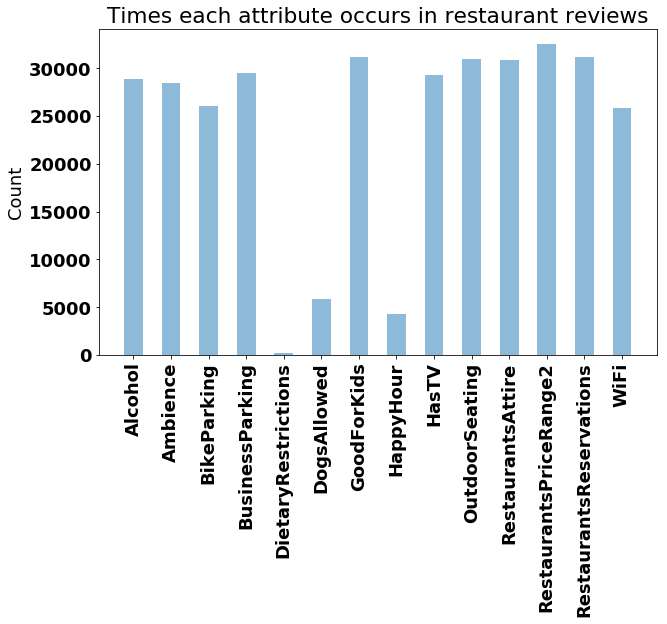

In [16]:
attributes2 = np.arange(len(attributes))

font = {'weight' : 'bold',
        'size'   : 18}
    
plt.rc('font', **font)
    
plt.figure(figsize=(10, 6))
plt.bar(attributes2, tally, align='center', alpha=0.5, width=0.5)
plt.xticks(attributes2, attributes, rotation='vertical')
plt.ylabel('Count')
plt.title('Times each attribute occurs in restaurant reviews')
 
plt.show()
plt.rcdefaults()

We find that DietaryRestrictions, DogsAllowed, and HappyHour occur in less than 5000 restaurant reviews.  We will remove them and calculate how many restaurant reviews contain all of the other attributes.

In [17]:
attributes = ['Alcohol',
              'Ambience',
              'BikeParking',
              'BusinessParking',
              'GoodForKids',
              'HasTV',
              'OutdoorSeating',
              'RestaurantsAttire',
              'RestaurantsPriceRange2',
              'RestaurantsReservations',
              'WiFi']

counter = 0
for i in range(0,len(resData)):
    
    ats = [i.split(':', 1)[0] for i in resData['attributes'][i]]
    contain = [i for i in ats if i in attributes]
    
    if len(contain) == len (attributes):
            counter += 1

print("Number of restaurants containing all attributes:  ", counter)
print("Total Number of restaurants:  ", len(resData))

Number of restaurants containing all attributes:   20731
Total Number of restaurants:   33967


Looking good!  By removing these three low occurring attributes we find 20731 out of 33967 restaurants that contain  all of the remaining 10 attributes.  We can now subset the restaurants by those that contain the attributes listed above.

In [18]:
resData2 = pd.DataFrame()

counter = 0
for i in range(0,len(resData)):
    
    ats = [i.split(':', 1)[0] for i in resData['attributes'][i]]
    contain = [i for i in ats if i in attributes]
    
    if len(contain) == len (attributes):
            counter += 1
            resData2 = resData2.append(resData.loc[i])

print("Number of restaurants containing all attributes:  ", counter)
print("Total Number of restaurants:  ", len(resData2))
resData2.head()

Number of restaurants containing all attributes:   20731
Total Number of restaurants:   20731


,attributes,categories,city,hours,name,review_count,stars,state
0,"[Alcohol: none, Ambience: {'romantic': False, ...","[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",Pizza Pizza,7.0,2.5,ON
1,"[Alcohol: none, Ambience: {'romantic': False, ...","[Tex-Mex, Mexican, Fast Food, Restaurants]",Scottsdale,"[Monday 10:0-22:0, Tuesday 10:0-22:0, Wednesda...",Taco Bell,9.0,2.5,AZ
4,"[Alcohol: none, Ambience: {'romantic': False, ...","[Fast Food, Mexican, Restaurants]",Toronto,"[Monday 10:45-22:0, Tuesday 10:45-22:0, Wednes...",Chipotle Mexican Grill,68.0,3.5,ON
5,"[Alcohol: full_bar, Ambience: {'romantic': Fal...","[Restaurants, Italian, Seafood]",Glendale,"[Monday 16:0-22:0, Tuesday 16:0-22:0, Wednesda...",Carrabba's Italian Grill,119.0,3.5,AZ
6,"[Alcohol: full_bar, Ambience: {'romantic': Fal...","[Restaurants, Mexican, American (Traditional)]",Amherst,"[Monday 11:0-22:0, Tuesday 11:0-22:0, Wednesda...",Don Tequila,22.0,3.5,OH


In [19]:
resData2 = resData2.reset_index(drop=True)   

Now that we have 20731 restaurants that all contain the same ten attributes we can begin to refactor them as features.   We will refactor the attributes as follows:

*  Alcohol - none (0) or full_bar/beer_and_wine (1)  
*  Ambience - see below
*  BikeParking - False (0) or True (1)  
*  BusinessParking - garage or street (0), no garage or street (1)  
*  GoodForKids - False (0) or True (1)  
*  HasTV:  False (0) or True (1)  
*  OutdoorSeating:  False (0) or True (1)  
*  RestaurantsAttire:  casual (0) or other (1)  
*  RestaurantsPriceRange2:  numeric value  
*  RestaurantsReservations:  False (0) or True (1)  
*  WiFi: no (0) or yes (1)  

We will create a new features data frame, newFeatures, containing this information for each restaurant.

In [20]:
attributes = ['Alcohol',
              'ambRomantic',
              'ambIntimate',
              'ambClassy',
              'ambHipster',
              'ambDivey',
              'ambTouristy',
              'ambTrendy',
              'ambUpscale',
              'ambCasual',
              'BikeParking',
              'BusinessParking',
              'DietaryRestrictions',
              'DogsAllowed',
              'GoodForKids',
              'HappyHour',
              'HasTV',
              'OutdoorSeating',
              'RestaurantsAttire',
              'RestaurantsPriceRange2',
              'RestaurantsReservations',
              'WiFi']

newFeatures = pd.DataFrame(0, index=np.arange(len(resData2)), columns=attributes)

In [21]:
for i in range(0,len(resData2)):
    ats = [i.split(':', 1) for i in resData2['attributes'][i]]
    
    # Alcohol
    if ['Alcohol', ' none'] not in ats:
        newFeatures.set_value(i,'Alcohol',1)
    
    # Ambience
    ambSplit = ats[1][1].replace('\'', "")
    
    if 'romantic' in ambSplit:
        if 'romantic: False' not in ambSplit:
            newFeatures.set_value(i,'ambRomantic',1)
    
    if 'intimate' in ambSplit:
        if 'intimate: False' not in ambSplit:
            newFeatures.set_value(i,'ambIntimate',1) 
    
    if 'classy' in ambSplit:   
        if 'classy: False' not in ambSplit:
            newFeatures.set_value(i,'ambClassy',1) 

    if 'hipster' in ambSplit:
        if 'hipster: False' not in ambSplit:
            newFeatures.set_value(i,'ambHipster',1)     
    
    if 'divey' in ambSplit:    
        if 'divey: False' not in ambSplit:
            newFeatures.set_value(i,'ambDivey',1)  
        
    if 'touristy' in ambSplit: 
        if 'touristy: False' not in ambSplit:
            newFeatures.set_value(i,'ambTouristy',1)  
        
    if 'trendy' in ambSplit:    
        if 'trendy: False' not in ambSplit:
            newFeatures.set_value(i,'ambTrendy',1) 
    
    if 'upscale' in ambSplit:    
        if 'upscale: False' not in ambSplit:
            newFeatures.set_value(i,'ambUpscale',1) 
    
    if 'casual' in ambSplit:    
        if 'casual: False' not in ambSplit:
            newFeatures.set_value(i,'ambCasual',1)
    
    # Bike Parking
    if ['BikeParking', ' False'] not in ats:
        newFeatures.set_value(i,'BikeParking',1)
    
    # BusinessParking
    parking = 'garage: False, street: False'
    for park in ats:
        if park[0] == 'BusinessParking':
            park = park[1].replace('\'', "")
            if parking in park:
                newFeatures.set_value(i,'BusinessParking',1)
    
    # Good for kids
    if ['GoodForKids', ' False'] not in ats:
        newFeatures.set_value(i,'GoodForKids',1)
    
    # Has TV
    if ['HasTV', ' False'] not in ats:
        newFeatures.set_value(i,'HasTV',1)
      
    # Outdoor seating
    if ['OutdoorSeating', ' False'] not in ats:
        newFeatures.set_value(i,'OutdoorSeating',1)
        
    # Restaurant Attire
    if ['RestaurantsAttire', ' casual'] not in ats:
        newFeatures.set_value(i,'RestaurantsAttire',1)
        
    # Price Range
    price = [i for i in ats if 'RestaurantsPriceRange2' in i][0][1]
    newFeatures.set_value(i, 'RestaurantsPriceRange2', price)
    
    # Reservations
    if ['RestaurantsReservations', ' False'] not in ats:
        newFeatures.set_value(i,'RestaurantsReservations',1)
        
    # WiFi
    if ['WiFi', ' no'] not in ats:
        newFeatures.set_value(i,'WiFi',1)

In [22]:
newFeatures.head()

,Alcohol,ambRomantic,ambIntimate,ambClassy,ambHipster,ambDivey,ambTouristy,ambTrendy,ambUpscale,ambCasual,...,DietaryRestrictions,DogsAllowed,GoodForKids,HappyHour,HasTV,OutdoorSeating,RestaurantsAttire,RestaurantsPriceRange2,RestaurantsReservations,WiFi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,2,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,2,1,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,1,0,2,0,0


Now we can join these new features to our existing restaurant data frame.

In [157]:
resDataFeatures = pd.concat([resData2, newFeatures], axis=1, join='inner')
resDataFeatures.head(3)

,attributes,categories,city,hours,name,review_count,stars,state,Alcohol,ambRomantic,...,DietaryRestrictions,DogsAllowed,GoodForKids,HappyHour,HasTV,OutdoorSeating,RestaurantsAttire,RestaurantsPriceRange2,RestaurantsReservations,WiFi
0,"[Alcohol: none, Ambience: {'romantic': False, ...","[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",Pizza Pizza,7.0,2.5,ON,0,0,...,0,0,1,0,1,0,0,1,0,1
1,"[Alcohol: none, Ambience: {'romantic': False, ...","[Tex-Mex, Mexican, Fast Food, Restaurants]",Scottsdale,"[Monday 10:0-22:0, Tuesday 10:0-22:0, Wednesda...",Taco Bell,9.0,2.5,AZ,0,0,...,0,0,1,0,0,0,0,1,0,0
2,"[Alcohol: none, Ambience: {'romantic': False, ...","[Fast Food, Mexican, Restaurants]",Toronto,"[Monday 10:45-22:0, Tuesday 10:45-22:0, Wednes...",Chipotle Mexican Grill,68.0,3.5,ON,0,0,...,0,0,1,0,0,0,0,2,0,0


We are almost there!  For our first attempt as classification we will consider the new features that we just added, city, and the review count.  Therefore for now we will remove the old attributes column, categories, hours, city, and name.  But first we need to create dummy variables for state.

In [158]:
dummy_ranks = pd.get_dummies(resDataFeatures['state'], prefix='state')
resDataFeatures = pd.concat([resDataFeatures, dummy_ranks], axis=1)

In [159]:
resDataFeatures.head(3)

,attributes,categories,city,hours,name,review_count,stars,state,Alcohol,ambRomantic,...,state_NI,state_NV,state_NY,state_OH,state_ON,state_PA,state_QC,state_SC,state_WI,state_WLN
0,"[Alcohol: none, Ambience: {'romantic': False, ...","[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",Pizza Pizza,7.0,2.5,ON,0,0,...,0,0,0,0,1,0,0,0,0,0
1,"[Alcohol: none, Ambience: {'romantic': False, ...","[Tex-Mex, Mexican, Fast Food, Restaurants]",Scottsdale,"[Monday 10:0-22:0, Tuesday 10:0-22:0, Wednesda...",Taco Bell,9.0,2.5,AZ,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[Alcohol: none, Ambience: {'romantic': False, ...","[Fast Food, Mexican, Restaurants]",Toronto,"[Monday 10:45-22:0, Tuesday 10:45-22:0, Wednes...",Chipotle Mexican Grill,68.0,3.5,ON,0,0,...,0,0,0,0,1,0,0,0,0,0


The last feature that we will consider is categories.  Every restaurant has a different combination of the same categories, so we will need to use our restaurant domain knowledge and pick categories that we think may be relevant to a restaurant's number of stars.

In [160]:
for i in range(0,30):
    print(resDataFeatures['categories'][i])

['Restaurants', 'Pizza', 'Chicken Wings', 'Italian']
['Tex-Mex', 'Mexican', 'Fast Food', 'Restaurants']
['Fast Food', 'Mexican', 'Restaurants']
['Restaurants', 'Italian', 'Seafood']
['Restaurants', 'Mexican', 'American (Traditional)']
['Restaurants', 'Waffles', 'Southern', 'Soul Food']
['Thai', 'Restaurants']
['Diners', 'Italian', 'Sandwiches', 'Breakfast & Brunch', 'Burgers', 'Canadian (New)', 'Restaurants']
['American (New)', 'Restaurants']
['American (Traditional)', 'Restaurants']
['Indian', 'Restaurants']
['Breakfast & Brunch', 'Restaurants']
['Food', 'Restaurants', 'Breakfast & Brunch', 'Coffee & Tea']
['Mexican', 'Restaurants']
['Restaurants', 'Breakfast & Brunch', 'Burgers', 'Sandwiches']
['Sports Bars', 'Nightlife', 'Bars', 'Pizza', 'Restaurants', 'Burgers']
['Chicken Wings', 'Fast Food', 'Restaurants']
['Korean', 'Restaurants']
['Juice Bars & Smoothies', 'Breakfast & Brunch', 'Salad', 'Restaurants', 'Coffee & Tea', 'Food', 'Sandwiches']
['Restaurants', 'Breakfast & Brunch', 'A

In [161]:
categories = ['Pizza', 
              'Italian', 
              'Tex-Mex', 
              'Seafood', 
              'Mexican', 
              'Thai', 
              'Breakfast & Brunch', 
              'Burgers', 
              'Bars', 
              'Juice Bars & Smoothies', 
              'Coffee & Tea', 
              'American (Traditional)',
              'American (New)',
              'Sandwiches',
              'Salad',
              'Chinese']

newFeatures2 = pd.DataFrame(0, index=np.arange(len(resDataFeatures)), columns=categories)

for i in range(0,len(resDataFeatures)):
    for x, j in enumerate(categories):
        if j in resDataFeatures['categories'][i]:
            newFeatures2.set_value(i, j, 1)

newFeatures2.head(3)

,Pizza,Italian,Tex-Mex,Seafood,Mexican,Thai,Breakfast & Brunch,Burgers,Bars,Juice Bars & Smoothies,Coffee & Tea,American (Traditional),American (New),Sandwiches,Salad,Chinese
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


And next we join these features to our existing features observation data frame.

In [162]:
resDataFeatures = pd.concat([resDataFeatures, newFeatures2], axis=1, join='inner')
resDataFeatures.head(3)

,attributes,categories,city,hours,name,review_count,stars,state,Alcohol,ambRomantic,...,Breakfast & Brunch,Burgers,Bars,Juice Bars & Smoothies,Coffee & Tea,American (Traditional),American (New),Sandwiches,Salad,Chinese
0,"[Alcohol: none, Ambience: {'romantic': False, ...","[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",Pizza Pizza,7.0,2.5,ON,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Alcohol: none, Ambience: {'romantic': False, ...","[Tex-Mex, Mexican, Fast Food, Restaurants]",Scottsdale,"[Monday 10:0-22:0, Tuesday 10:0-22:0, Wednesda...",Taco Bell,9.0,2.5,AZ,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[Alcohol: none, Ambience: {'romantic': False, ...","[Fast Food, Mexican, Restaurants]",Toronto,"[Monday 10:45-22:0, Tuesday 10:45-22:0, Wednes...",Chipotle Mexican Grill,68.0,3.5,ON,0,0,...,0,0,0,0,0,0,0,0,0,0


Great!  The last thing to do is drop the features that we no longer need.

In [163]:
resDataFeatures = resDataFeatures.drop('hours', axis=1)
resDataFeatures = resDataFeatures.drop('attributes', axis=1)
resDataFeatures = resDataFeatures.drop('categories', axis=1)
resDataFeatures = resDataFeatures.drop('name', axis=1)
resDataFeatures = resDataFeatures.drop('city', axis=1)
resDataFeatures = resDataFeatures.drop('state', axis=1)
resDataFeatures.head(3)

,review_count,stars,Alcohol,ambRomantic,ambIntimate,ambClassy,ambHipster,ambDivey,ambTouristy,ambTrendy,...,Breakfast & Brunch,Burgers,Bars,Juice Bars & Smoothies,Coffee & Tea,American (Traditional),American (New),Sandwiches,Salad,Chinese
0,7.0,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.0,2.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68.0,3.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Whew, that was a lot of data reformatting.  We are finally ready to start looking at the data.

## Exploratory Data Analysis

We begin by examining the distribution of reviews, or stars.  First we need to look at the summary statistics for the number of stars.

In [164]:
resDataFeatures['stars'].describe()

count    20731.000000
mean         3.606531
std          0.630851
min          1.000000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: stars, dtype: float64

We expect the lowest score to be 1 and the maximum score to be 5, so it appears there are not any outliers in this data set.  The mean number of stars is 3.6, and the median is 3.5, indicating a left skew.  We can next look at the distribution with a histogram.

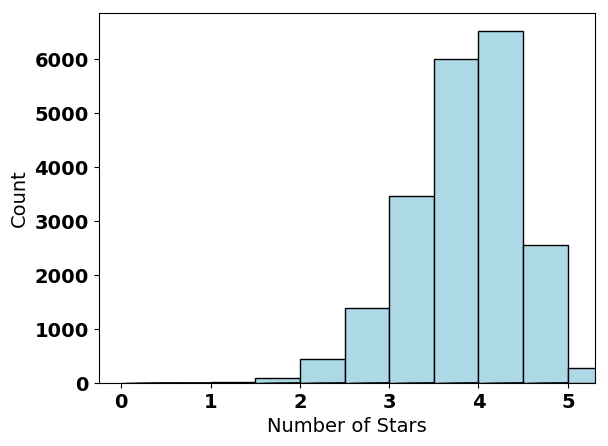

In [165]:
font = {'weight' : 'bold',
        'size'   : 14}

bins = list(np.arange(0, 5.1, 0.05))

plt.rc('font', **font)
resDataFeatures['stars'].plot.hist(bins=bins, width=0.5, color='lightblue', edgecolor = "black")
plt.xlabel("Number of Stars")
plt.ylabel("Count")

plt.show()
plt.rcdefaults()

We next look to see if there is a correlation between the number of stars a restaurant receives the number of reviews.  First we see how many reviews restaurants typically get.

In [166]:
resDataFeatures['review_count'].describe()

count    20731.000000
mean       101.577589
std        192.971325
min          3.000000
25%         24.000000
50%         50.000000
75%        108.000000
max       6414.000000
Name: review_count, dtype: float64

The average number of reviews is 97, and the standard deviation is 188.  There appears to be significant outliers, in particular a restaurant that has received 6414 reviews.

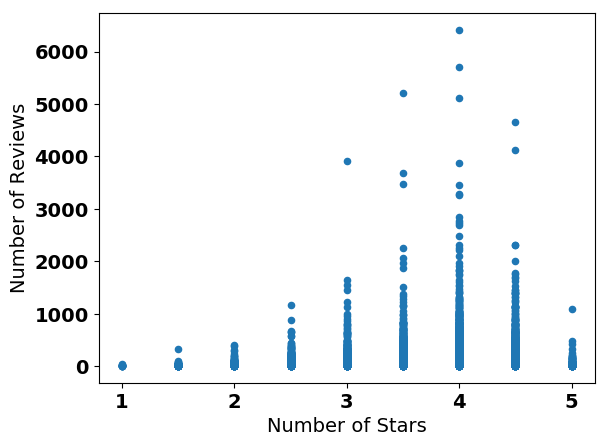

In [167]:
font = {'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
resDataFeatures.plot.scatter(x='stars', y='review_count')
plt.xlabel("Number of Stars")
plt.ylabel("Number of Reviews")

plt.show()
plt.rcdefaults()

The relationship between the number of stars and the number of reviews is not immediately obvious, although it appears there may be a weak positive linear relationship between the two variables when the number of stars is between 1 and 4.  This may be because people do not go to restaurants with a low star rating, thus there will be less reviews.  

We next look at the average reviews for different types of restaurants based on food offerings.   

In [270]:
# create a dataframe that will store star averages (first index) and stdevs (second index)
resTypes = pd.DataFrame(0, index=np.arange(2), columns=categories)

for i, name in enumerate(categories):
    count = resDataFeatures['stars'].groupby(resDataFeatures[name]).count() 
    mean = resDataFeatures['stars'].groupby(resDataFeatures[name]).mean()
    stdev = resDataFeatures['stars'].groupby(resDataFeatures[name]).std()
    resTypes.loc[0, name] = mean[1]
    resTypes.loc[1, name] = stdev[1]

resTypes.head()

,Pizza,Italian,Tex-Mex,Seafood,Mexican,Thai,Breakfast & Brunch,Burgers,Bars,Juice Bars & Smoothies,Coffee & Tea,American (Traditional),American (New),Sandwiches,Salad,Chinese
0,3.581835,3.651492,3.177419,3.640074,3.533922,3.694222,3.613688,3.42487,3.537795,3.873518,3.898727,3.394261,3.634857,3.685272,3.671521,3.448568
1,0.644206,0.579339,0.626653,0.569129,0.655956,0.540928,0.632951,0.68872,0.588370,0.625048,0.578074,0.627114,0.585920,0.654684,0.641213,0.557412


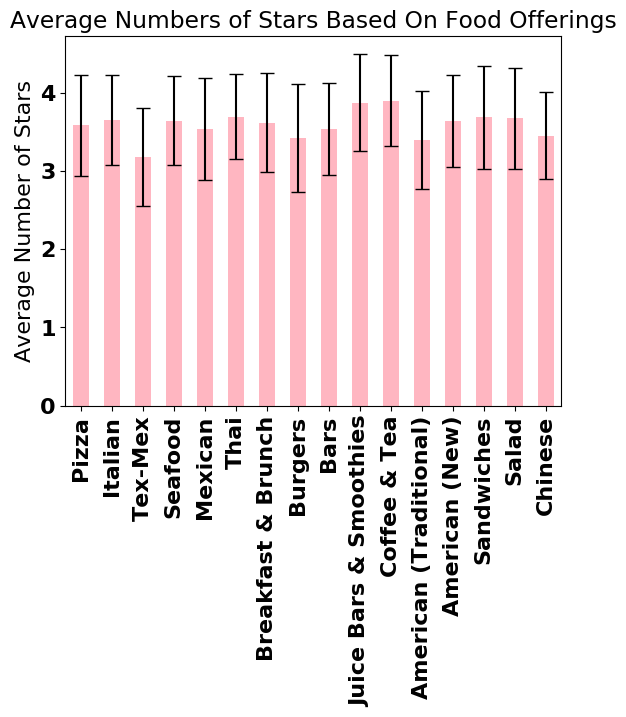

In [228]:
# plot the data

font = {'weight' : 'bold',
        'size'   : 16}
    
plt.rc('font', **font)

plt.ylabel('Average Number of Stars')

font = {'weight' : 'bold',
        'size'   : 14}
    
plt.rc('font', **font)

plt.title('Average Numbers of Stars Based On Food Offerings')

resTypes.ix[0].plot.bar(color='lightpink', yerr=resTypes.ix[1], capsize = 5)

plt.show()
plt.rcdefaults()

As shown above, Coffee and Tea restaurants have the highest average number of stars (3.90) and Tex-Mex type restaurants have the lowest (3.18), indicating that restaurant owners may consider serving Coffee and Tea to the extent that this attribute shows up in their Yelp rating.  

We next look at restaurant attribute RestaurantsPriceRange2.

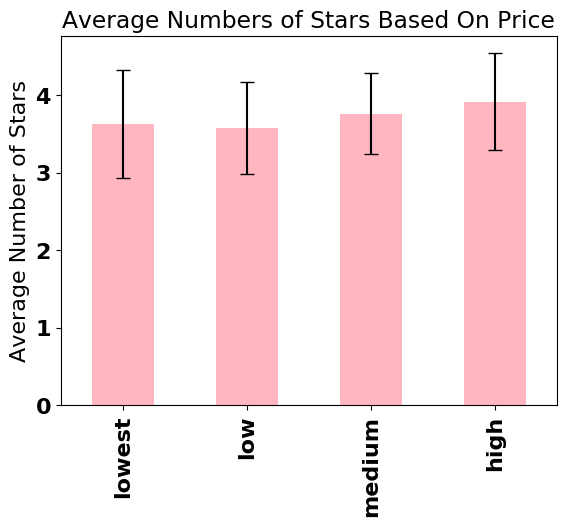

In [264]:
prices = ['RestaurantsPriceRange2']
pricesHead = ['lowest', 'low', 'medium', 'high']

# create a dataframe that will store star averages (first index) and stdevs (second index)
resPrices = pd.DataFrame(0, index=np.arange(2), columns=pricesHead)

for i, name in enumerate(prices):
    mean = resDataFeatures['stars'].groupby(resDataFeatures[name]).mean()
    stdev = resDataFeatures['stars'].groupby(resDataFeatures[name]).std()
    resPrices.loc[0, 'lowest'] = mean[1]
    resPrices.loc[0, 'low'] = mean[2]
    resPrices.loc[0, 'medium'] = mean[3]
    resPrices.loc[0, 'high'] = mean[4]
    
    resPrices.loc[1, 'lowest'] = stdev[1]
    resPrices.loc[1, 'low'] = stdev[2]
    resPrices.loc[1, 'medium'] = stdev[3]
    resPrices.loc[1, 'high'] = stdev[4]

resPrices.head()

# plot the data
font = {'weight' : 'bold',
        'size'   : 16}
    
plt.rc('font', **font)

plt.ylabel('Average Number of Stars')

font = {'weight' : 'bold',
        'size'   : 14}
    
plt.rc('font', **font)

plt.title('Average Numbers of Stars Based On Price')

resPrices.ix[0].plot.bar(color='lightpink', yerr=resPrices.ix[1], capsize = 5)

plt.show()
plt.rcdefaults()

We see that the restaurants with the highest prices have, on average, the highest number of stars.  We are now ready to build a SVM.  

## Support Vector Machines

We are finally to the point where we can begin building a support vector machine to predict restaurant reviews.  Support vector machines are applicable for both binary and multiclass classification, although the relevant metrics for model performance are slightly different.  Here we will re-formulate this problem as one of binary classification.  To do this we will split the restaurants into two groups:  those with more than 4 stars (1) and those with less than 3 stars (0).

In [138]:
# remove restaurants that have between 3 and 4 stars
resDataFeatures = resDataFeatures.drop(resDataFeatures[(resDataFeatures['stars'] < 4) & (resDataFeatures['stars'] > 3)].index)
resDataFeatures = resDataFeatures.reset_index(drop=True)

# if a restaurant has greater than 4 stars assign it a value of 1, otherwise 0
for i in range(0,len(resDataFeatures)):
    if resDataFeatures['stars'][i] >= 4:
        resDataFeatures.set_value(i,'stars',1)
    else: 
        resDataFeatures.set_value(i,'stars',0)

print("Number of restaurats classified as greater than or equal to 4 stars (1):  ",
      len(resDataFeatures[(resDataFeatures['stars'] > 0)]))

print("Number of restaurats classified as less than or equal to 3 stars (0):  ",
      len(resDataFeatures[(resDataFeatures['stars'] == 0)]))

Number of restaurats classified as greater than or equal to 4 stars (1):   9339
Number of restaurats classified as less than or equal to 3 stars (0):   5396


We are now ready to build our SVM.  First, we will normalize the feature data set and then split the data into test and training sets.

In [139]:
# split the data into test and training sets and scale
split = np.random.rand(len(resDataFeatures)) < 0.7
resTrain = resDataFeatures[split]
resTrain_features = resTrain.drop(['stars'], axis=1)
resTrain_labels = resTrain['stars']

# scale the training data
scaler = StandardScaler()
resTrain_Scaled = scaler.fit_transform(resTrain_features)

# process the test data
resTest = resDataFeatures[~split]
resTest_features = resTest.drop(['stars'], axis=1)
resTest_labels = resTest['stars']

#scale the test data
resTest_scaled = scaler.transform(resTest_features)


We will next perform hyperparameter tuning using GridSearchCV.  We will consider one kernel (rbf) and evaluate three different values of 'C' (as described above) for each kernel.  The rbf kernel also contains an additional hyperparameter, gamma.  Note we will also use 10 fold cross validation across the test data set.

In [104]:
# define hyperparameter grid and tuning via gridsearch
parameter_candidates = [
  {'C': [100, 1000, 10000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
]

svr = svm.SVC()
clf = GridSearchCV(svr, parameter_candidates, n_jobs=1, cv=10)
clf.fit(resTrain_features, resTrain_labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [100, 1000, 10000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [106]:
# find the best hyperparameter values from tuning
print('Best C:',clf.best_estimator_.C)
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

Best C: 10000
Best Kernel: rbf
Best Gamma: 0.001


We can now build a SVM model using the optimal values for the hyperparameters.

In [140]:
SVMmodel = svm.SVC(kernel='rbf', C=10000, gamma=.001) 
SVMmodel.fit(resTrain_Scaled, resTrain_labels)
SVMmodel.score(resTest_scaled, resTest_labels)

0.72560839473096672

As shown above, we achieved an accuracy of 73% - not bad!  This means that we labeled 73% of the observations in the test data set correctly, however an accuracy value can be misleading for unbalanced data.  We can get more information by examining the confusion matrix.

In [147]:
resPredict = SVMmodel.predict(resTest_scaled)
preds = pd.DataFrame(confusion_matrix(resTest_labels, resPredict))
preds.columns = ['Predicted < 3 Stars', 'Predicted > 4 Stars']
preds.index = ['Actual < 3 Stars', 'Actual > 4 Stars']
preds

,Predicted < 3 Stars,Predicted > 4 Stars
Actual < 3 Stars,920,710
Actual > 4 Stars,519,2330


We further examine the performance of our model with the following metrics:  

***  precision:  when the model predicts that a restaurant has more than four stars, how often is it right? **  
* precision = true positive / (true positive + false positive)  

***  recall (or true positive rate):  of the restaurants that actually have > 4 stars, how many did the model correctly label as such? **  
* recall = true positive / (true positive + false negative)  

***  accuracy:  how many observations did the model correctly label? **  
* accuracy = (true positive + true negative) / (total number of observations)  

***  false positive rate:  how many observations did the model correctly label? **  
* false positive rate = false positive / (true negative + false positive)  

In [155]:
print('precision:  ', 2330/(2330+710))
print('recall:  ', 2330/(2330+519))
print('accuracy:  ', (2330+920)/(2330+920+519+710))
print('false positive rate:  ', (710/(920+710)))

precision:   0.7664473684210527
recall:   0.8178308178308178
accuracy:   0.7256083947309667
false positive rate:   0.43558282208588955


In summary, we were able to build a SVM model to predict wether a restaurant on Yelp will get < 3 or > 4 stars with 73% accuracy.  This is interesting (to me at least) because this model only includes features about characteristics of the restaurant, such as whether or not WiFi is available, and these are things that an owner can control relatively easily.  